# Guide to Network Analysis (Part 3 - Generate Service Area)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2">Data</a></span><ul class="toc-item"><li><span><a href="#Define-Facilities-Layer" data-toc-modified-id="Define-Facilities-Layer-2.1">Define Facilities Layer</a></span></li></ul></li><li><span><a href="#Methods" data-toc-modified-id="Methods-3">Methods</a></span><ul class="toc-item"><li><span><a href="#Method-1---using-arcgis.network.analysis.generate_service_areas" data-toc-modified-id="Method-1---using-arcgis.network.analysis.generate_service_areas-3.1">Method 1 - using arcgis.network.analysis.generate_service_areas</a></span><ul class="toc-item"><li><span><a href="#Tabularizing-the-response-from-generate_service_area" data-toc-modified-id="Tabularizing-the-response-from-generate_service_area-3.1.1">Tabularizing the response from generate_service_area</a></span></li><li><span><a href="#Visualizing-the-response-from-generate_service_area" data-toc-modified-id="Visualizing-the-response-from-generate_service_area-3.1.2">Visualizing the response from generate_service_area</a></span></li><li><span><a href="#Constructing-service-areas-for-different-times-of-the-day" data-toc-modified-id="Constructing-service-areas-for-different-times-of-the-day-3.1.3">Constructing service areas for different times of the day</a></span></li></ul></li><li><span><a href="#Method-2---using-arcgis.features.use_proximity.create_drive_time_areas" data-toc-modified-id="Method-2---using-arcgis.features.use_proximity.create_drive_time_areas-3.2">Method 2 - using arcgis.features.use_proximity.create_drive_time_areas</a></span><ul class="toc-item"><li><span><a href="#With-output_name-specified" data-toc-modified-id="With-output_name-specified-3.2.1">With output_name specified</a></span></li><li><span><a href="#Without-output_name-specified" data-toc-modified-id="Without-output_name-specified-3.2.2">Without output_name specified</a></span></li></ul></li></ul></li><li><span><a href="#What's-next?" data-toc-modified-id="What's-next?-4">What's next?</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5">References</a></span></li></ul></div>

## Introduction

Now we have learned about Network Datasets and Network Analysis Services, and how to find routes from one point to another, and among multiple points, let's move onto the third topic - how to generate Service Area. Please refer to the road map below if you want to revisit the previous topics or jump to the next topic -

 - Network Dataset and Network Analysis services [Part 1](../part1-introduction-to-network-analysis) 
 - Find Routes [Part 2](../part2-find-routes)
 - Generate Service Area (You are here!)
 - Find Closest Facility [Part 3](../part4-find-closest-facilities)
 - Generate Origin Destination Cost Matrix [Part 5](../part5-generate-od-cost-matrix)
 - Solve Location Allocation [Part 6](../part6-solve-location-allocation)
 - Vehicle Routing Problem Service [Part 7](../part7-vehicle-routing-problem)

This part of guide to Networking Analysis will help you find out what's occurring within a set distance of a feature, or what's within traveling range (measured using distance, time, or cost), and bring you these benefits ([1](#references)):

 - **allow you to identify the area - and the features inside the area - affected by an event or activity**. For instance, a city planner needs to notify residents within 500 feet of a proposed liquor store of its forthcoming.
 - **let you monitor activities in the area**. For instance, staff working at state forestry department needs to monitor logging that should not happen within 100 meters buffer along streams.
 - **help define the area served by a facility**. For example, the chief of fire department wants to know which streets are within 3-minute drive of a fire station, and/or a GIS analyst in search of a good retail store location wants to find out how many people live within a 15-minute drive of a proposed store location.
 - **help delineate areas that are suitable for/capable of supporting a specific use**. Take a wildlife biologist as an example, he/she might need to map the area within a half-mile of streams combined with vegetation type, slope, and other factors that could be used to identify prime deer habitats.

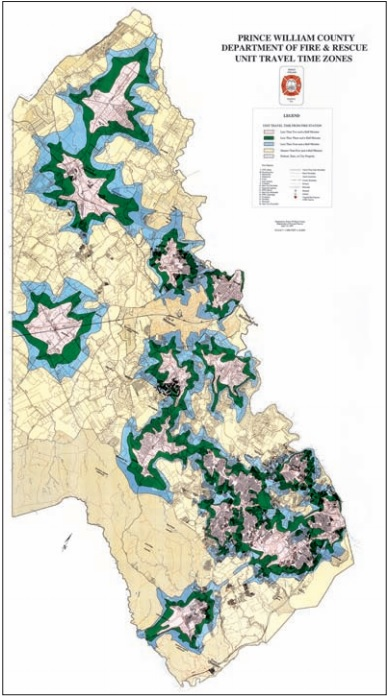

Fig 1. The department of fire and rescue in Prince William County , VA, mapped areas within 5, 10, and 15 minutes of drive to fire stations, in order to help decide where to build new stations ([1](#references)). 

To find what's nearby, the first step is to decide how to measure the "nearness". You can measure by straight-line distance, distance or cost over a network, or cost over a surface ([1](#references)).

 - When what's nearby is defined by `straight-line distance`, you need to specify the source feature and the distance, then the ArcGIS API for Python finds the area or the surrounding features within the distance. This approach is good for creating a boundary or selecting features at a set distance around a source (as shown in Fig 2(L)).
 - When what's nearby is defined by `distance or cost over a network`, you need to specify the source locations and a distance (or travel cost) along each linear feature, then the API finds which segments of the network are within the distance/cost. This approach is good for finding what's within a travel distance or cost of a location, over a fixed network (as shown in Fig 2(M)).
 - When what's nearby is defined by `cost over a surface`, you need to specify the location of the source features and a travel cost, then the API creates a new layer showing the travel cost from each source feature. This approach is good for calculating overland travel cost (as shown in Fig 2(R)).


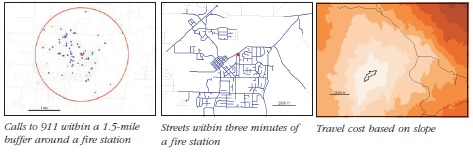

Fig 2. (Left) Creates a buffer by straight-line distance measurement; (Middle) Calculates distance or cost over a network; (Right) Uses the travel cost map based on slopes from source to destinations ([1](#references)).

`Service areas` are commonly used to visualize and measure accessibility. For example, a three-minute, drive-time polygon around a grocery store can determine which residents are able to reach the store within three minutes and are thus more likely to shop there  ([2](#references)). Service areas also help evaluate accessibility. Concentric service areas show how accessibility varies. Once service areas are created, you can use them to identify how much land, how many people, or how much of anything else is within the neighborhood or region. Service area solver provides functionality for finding out how far a vehicle could go within a specified time or distance limit.

Now that we have learned why generating service area is needed, and the basis of measuring the nearness, it is time to play with some code!

## Data

The first step to everything is always importing all required modules and establishing a GIS connection to ArcGIS Online organization or your enterprise for ArcGIS.

If you have already set up a profile to connect to your ArcGIS Online organization, execute the cell below to load the profile and create the GIS class object. If not, use a traditional username/password log-in e.g. `my_gis = GIS('https://www.arcgis.com', 'username', 'password', verify_cert=False, set_active=True)`

In [1]:
from arcgis.gis import GIS
import arcgis.network as network
from arcgis.features import FeatureLayer, Feature, FeatureSet, use_proximity
from arcgis.map.symbols import PictureMarkerSymbolEsriPMS, SimpleFillSymbolEsriSFS, SimpleLineSymbolEsriSLS
from arcgis.map.popups import PopupInfo

import pandas as pd
import datetime as dt
import time

In [2]:
my_gis = GIS(profile='your_online_profile')

### Define Facilities Layer

If you do not have access to the hospital layer provided by `Esri_livingatlas` as referenced in the cell below, an alternative approach is for you to download the hospital listing of San Bernadino County from this <a href="https://data.chhs.ca.gov/datastore/dump/641c5557-7d65-4379-8fea-6b7dedbda40b?q=&sort=_id+asc&fields=OSHPD_ID%2CFACILITY_NAME%2CLICENSE_NUM%2CFACILITY_LEVEL_DESC%2CDBA_ADDRESS1%2CDBA_CITY%2CDBA_ZIP_CODE%2CCOUNTY_CODE%2CCOUNTY_NAME%2CER_SERVICE_LEVEL_DESC%2CTOTAL_NUMBER_BEDS%2CFACILITY_STATUS_DESC%2CFACILITY_STATUS_DATE%2CLICENSE_TYPE_DESC%2CLICENSE_CATEGORY_DESC%2CLATITUDE%2CLONGITUDE&filters=%7B%22COUNTY_CODE%22%3A+%5B%2236%22%5D%7D&format=csv">source</a> and publish the csv to the organization before proceeding forward.

<Item title:"hospitals_SB_county" type:Feature Layer Collection owner:arcgis_python>
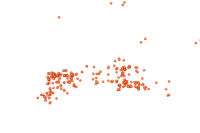

In [3]:
hospital_item = my_gis.content.get("e438435c220b4713b0a5779a8ebb5d16")
hospital_item

From the Feature Layer item, we would derive the url of its first Feature Service, and create into a Feature Layer class object, which will then be used to make queries.

In [4]:
hospital_fl = FeatureLayer(hospital_item.url + "/0")
hospital_fl

<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/hospitals_SB_county/FeatureServer/0">

In [5]:
hospital_fl = FeatureLayer(hospital_item.url + "/0")
facilities = hospital_fl.query(where="DBA_CITY='Redlands' or DBA_CITY='Loma Linda'", as_df=False)
display(facilities)

<FeatureSet> 36 features

If the procedures all go well, you will be seeing a `facilities` object of a FeatureSet that contains 33 features. With such, we can draw the output FeatureSet with customized symbology in the map widget below.


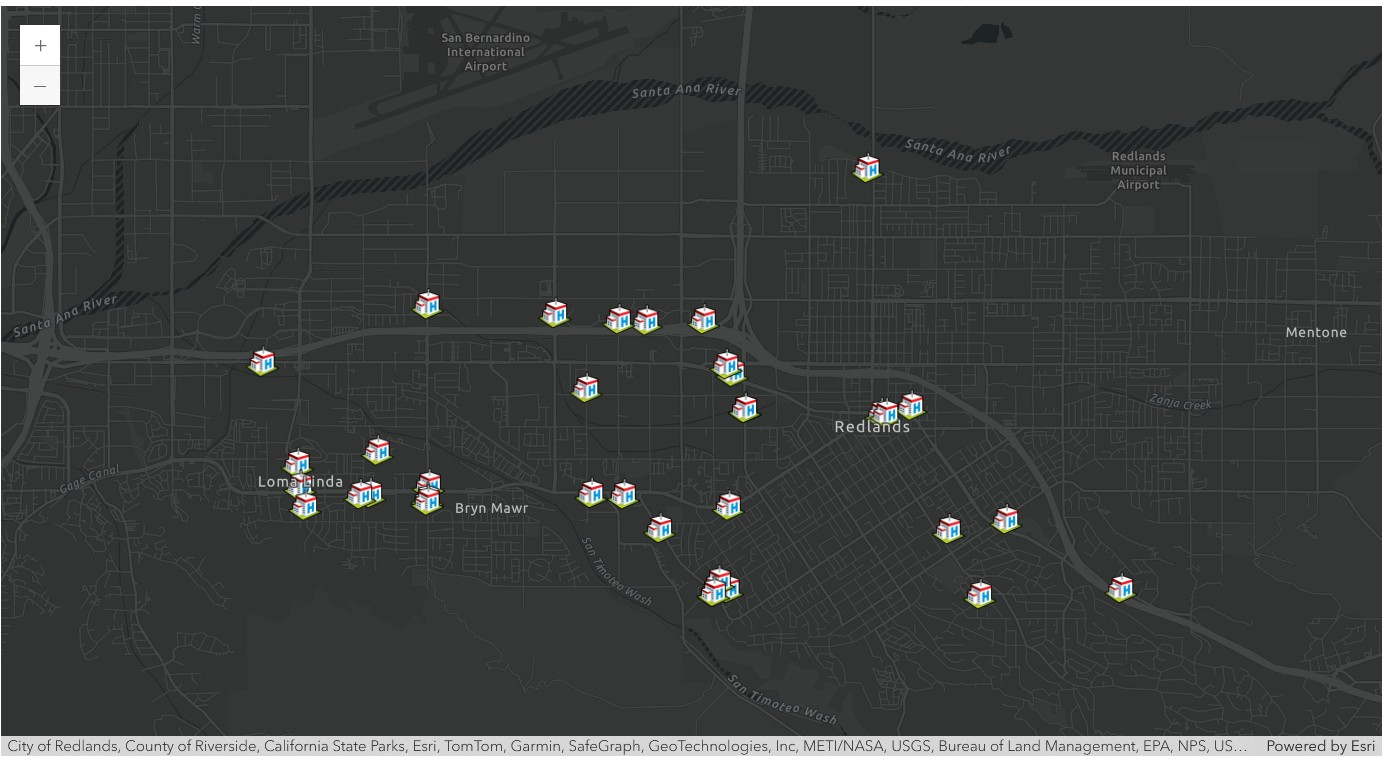

In [83]:
map1 = my_gis.map('SAN BERNARDINO, CA')
map1

In [62]:
hospital_symbol = PictureMarkerSymbolEsriPMS(**{"type":"esriPMS",
                                  "url":"http://static.arcgis.com/images/Symbols/SafetyHealth/Hospital.png",
                                  "contentType":"image/png","width":20,"height":20})

map1.content.draw(facilities, symbol=hospital_symbol)

In [63]:
map1.zoom_to_layer(facilities)

In [82]:
map1.basemap.basemap = 'arcgis-dark-gray'

## Methods

The ArcGIS API for Python provides three ways to solve a service area generation problem, which are namely, **ServiceAreaLayer.solve**, **generate_service_areas**, and **create_drive_time_areas**.

| Operation       |  network.analysis       | features.use_proximity |
|-----------------|-------------------------|------------------------|
| Route           |  find_routes            | plan_routes        |
| ServiceArea     |  **generate_service_areas** | **create_drive_time_areas**|
| ClosestFacility |  find_closest_facilities| find_nearest |

These three methods are defined in different modules of the arcgis package, and will make distinct REST calls in the back end. A key distinction between **ServiceAreaLayer.solve** and **generate_service_areas**, **create_drive_time_areas** is, the former is meant for custom or advanced service area creating workflows where you need to publish your own Network Analysis layers. The latter tools work against service are generation services hosted on ArcGIS Online or available on your Enterprise via proxy services and will cost you credits.

In this part of guide, we will walk through the workflows of using `network.analysis.generate_service_areas()` and `features.use_proximity.create_drive_time_areas()` in solving the same problem - creating service areas for `facilities` defined as hospitals here, and further explore the differences in the process.

### Method 1 - using arcgis.network.analysis.generate_service_areas

The `generate_service_areas` tool determines network service areas around facilities. A network service area is a region that encompasses all streets that can be accessed within a given distance or travel time from one or more facilities. For instance, the 10-minute service area for a facility includes all the streets that can be reached within 10 minutes from that facility. Service areas are commonly used to visualize and measure accessibility. For example, a three-minute drive-time polygon around a grocery store can determine which residents are able to reach the store within three minutes and are thus more likely to shop there. Parameters used in the example below include:
 - `facilities`: Facilities (FeatureSet). Required parameter. The facilities around which service areas are generated.
 - `break_values`: Break Values (str). Required parameter. Specifies the size and number of service area polygons to generate for each facility
 - `break_units`: Break Units (str). Required parameter. The unit for the Break Values parameter.
 - `time_of_day`: Time of Day (datetime). Optional parameter. The time to depart from or arrive at the facilities.
 
For more information, please refer to the <a href="https://developers.arcgis.com/python/api-reference/arcgis.network.analysis.html?highlight=generate_service_area#arcgis.network.analysis.generate_service_areas">API help doc</a>.

In [10]:
list_of_breaks = [5,10,15]
if isinstance(list_of_breaks, list):
    string_of_breaks = ' '.join(map(str, list_of_breaks))
    print(string_of_breaks)

5 10 15


In [11]:
%%time

current_time = dt.datetime.now() 

result1 = network.analysis.generate_service_areas(facilities=facilities, break_values=string_of_breaks, 
                                                  break_units="Minutes", time_of_day=current_time)

CPU times: total: 875 ms
Wall time: 16.5 s


In [12]:
print("Is the tool finished successfully?", result1.solve_succeeded)

Is the tool finished successfully? True


In [13]:
result1

ToolOutput(service_areas=<FeatureSet> 108 features, solve_succeeded=True, output_network_analysis_layer=None, output_facilities=<FeatureSet> 36 features, output_service_area_lines=None, output_result_file=None, output_network_analysis_layer_package=None, usage_cost={'numObjects': 108, 'credits': 54.0})

As shown above, the output `result1` is of type `arcgis.geoprocessing._support.ToolOutput` that contains multiple components, e.g. `service_areas`, `output_facilities` and `output_service_area_lines` are FeatureSet objects which will be further explored in the following:

#### Tabularizing the response from generate_service_area

We can read the `service_areas` component of the returned object as DataFrame:

In [14]:
cols = ['FromBreak', 'ToBreak', 'COUNTY_CODE', 'COUNTY_NAME', 'DBA_ADDRESS1', 'DBA_CITY',  \
        'DBA_ZIP_CODE', 'FACILITY_LEVEL_DESC', 'FACILITY_NAME', 'FACILITY_STATUS_DATE', 'FACILITY_STATUS_DESC', \
        'LICENSE_CATEGORY_DESC', 'LICENSE_NUM', 'LICENSE_TYPE_DESC', 'Name', \
        'OSHPD_ID', 'TOTAL_NUMBER_BEDS']

In [15]:
df = result1.service_areas.sdf[cols]
df.sort_values('FromBreak', inplace=True, ascending=True)
df.head()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME         DBA_ADDRESS1  \
2         0.0      5.0           36  San Bernardino    11234 Anderson St   
5         0.0      5.0           36  San Bernardino      25271 BARTON RD   
11        0.0      5.0           36  San Bernardino    11234 ANDERSON ST   
8         0.0      5.0           36  San Bernardino    11375 ANDERSON ST   
14        0.0      5.0           36  San Bernardino  24674 Redlands Blvd   

      DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
2   Loma Linda         92354     Parent Facility   
5   LOMA LINDA         92354     Parent Facility   
11  LOMA LINDA         92354     Parent Facility   
8   LOMA LINDA         92354     Parent Facility   
14  Loma Linda         92354     Parent Facility   

                                FACILITY_NAME FACILITY_STATUS_DATE  \
2   LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL           2014-11-16   
5         HERITAGE GARDENS HEALTH CARE CENTER           1966-01-11   
11       LOMA LINDA UNIVERSITY MEDICAL CENTER           1946-01-01   
8         LOMA LINDA UNIVERSITY KIDNEY CENTER           1977-12-19   
14                     CARELIFE HOSPICE, INC.           2020-07-14   

   FACILITY_STATUS_DESC        LICENSE_CATEGORY_DESC  LICENSE_NUM  \
2                  Open  General Acute Care Hospital    550002873   
5                  Open     Skilled Nursing Facility    240000146   
11                 Open  General Acute Care Hospital    240000169   
8                  Open      Chronic Dialysis Clinic    240000011   
14                 Open                      Hospice    550005664   

             LICENSE_TYPE_DESC                 Name   OSHPD_ID  \
2                     Hospital  Location 13 : 0 - 5  106364502   
5      Long Term Care Facility  Location 18 : 0 - 5  206361195   
11                    Hospital   Location 8 : 0 - 5  106361246   
8                       Clinic  Location 25 : 0 - 5  306360016   
14  Home Health Agency/Hospice  Location 34 : 0 - 5  406362791   

    TOTAL_NUMBER_BEDS  
2                 343  
5                 110  
11                371  
8                <NA>  
14               <NA>

In [15]:
df.tail()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME        DBA_ADDRESS1  \
78        10.0     15.0           36  San Bernardino  700 E HIGHLAND AVE   
102       10.0     15.0           36  San Bernardino     42 W Hilton Ave   
99        10.0     15.0           36  San Bernardino      35 Blue Jay Ln   
96        10.0     15.0           36  San Bernardino          301 9th St   
105       10.0     15.0           36  San Bernardino      812 Concord Ln   

     DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
78   REDLANDS         92374     Parent Facility   
102  Redlands         92373     Parent Facility   
99   Redlands         92374     Parent Facility   
96   Redlands         92374     Parent Facility   
105  Redlands         92374     Parent Facility   

                        FACILITY_NAME FACILITY_STATUS_DATE  \
78   HIGHLAND CARE CENTER OF REDLANDS           1960-01-18   
102                 HILTON MANOR, LLC           2016-11-10   
99                BLUE JAY MANOR, LLC           2017-10-03   
96         WINGS OF HOPE HOSPICE, INC           2017-01-01   
105     SERENE CONGREGATE LIVING, LLC           2018-01-18   

    FACILITY_STATUS_DESC              LICENSE_CATEGORY_DESC  LICENSE_NUM  \
78                  Open           Skilled Nursing Facility    240000114   
102                 Open  Congregate Living Health Facility    550003708   
99                  Open  Congregate Living Health Facility    550003969   
96                  Open                            Hospice    550003546   
105                 Open  Congregate Living Health Facility    550004194   

              LICENSE_TYPE_DESC                   Name   OSHPD_ID  \
78      Long Term Care Facility  Location 16 : 10 - 15  206361114   
102     Long Term Care Facility  Location 24 : 10 - 15  206364580   
99      Long Term Care Facility  Location 15 : 10 - 15  206361004   
96   Home Health Agency/Hospice   Location 2 : 10 - 15  406361298   
105     Long Term Care Facility  Location 14 : 10 - 15  206360023   

     TOTAL_NUMBER_BEDS  
78                  80  
102                  6  
99                   6  
96                <NA>  
105                  6

#### Visualizing the response from generate_service_area

The service area at these breaks for each hospitals can then be rendered as rings on the map widget.


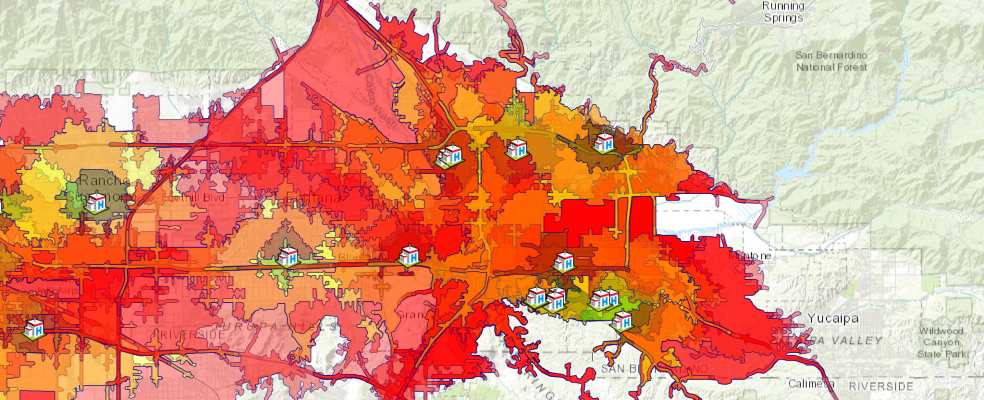

In [46]:
map2 = my_gis.map('SAN BERNARDINO, CA')
map2

In [35]:
#set outline for each service area
outline = SimpleLineSymbolEsriSLS(**{"color":[0,0,128,255], "type":"esriSLS", "style":"esriSLSSolid", "width":0.25})

In [36]:
colors = {5: [0, 128, 0, 90], 
          10: [255, 255, 0, 90], 
          15: [255, 0, 0, 90]}

for service_area in result1.service_areas.features:

    #set colors based on drive time
    color = colors[service_area.attributes['ToBreak']]

    fill_symbol = SimpleFillSymbolEsriSFS(**{"type": "esriSFS","style": "esriSFSSolid",
               "color": color,
               "outline":outline})
    
    #set popup
    popup=PopupInfo(**{"title": "Service area", 
           "content": "{} minutes".format(service_area.attributes['ToBreak'])})
    
    #draw service area
    map2.content.draw(service_area.geometry, symbol=fill_symbol, popup=popup, 
              attributes={"title": service_area.attributes['Name']})

map2.content.draw(facilities, symbol=hospital_symbol)

In [37]:
map2.zoom_to_layer(facilities)

In [38]:
item_properties = {
    "title": "Hospital Service Areas of San Bernadino County (2)",
    "tags" : "Service area",
    "snippet": " Hospital Service Areas of San Bernadino County",
    "description": "a web map of Hospital Service Areas of San Bernadino County"
}

item = map2.save(item_properties)
item

<Item title:"Hospital Service Areas of San Bernadino County (2)" type:Web Map owner:arcgis_python>

#### Constructing service areas for different times of the day

Now, let's expand the topic to an advanced level, by looking at a slightly more complicated application of generating service area. Traffic conditions tend to be varied for rush hours, day time and evening, it is essential that the Emergency Response Center makes sure the ambulance can also get to the patient at the earliest convenience. Instead of solving the problem based on a specified time of a day, let's construct the service areas for different times of the day, for instance, at 6AM, 10AM, 14PM, 18PM, 22PM, respectively.

Instead of looking at the service areas of all 33 hospitals in the area, we will just pick one of the hospitals and construct service areas for this single `facility`.

Also note that, we are changing the breaks from [5,10,15] to [3,9,15] here.

In [39]:
times = [dt.datetime(2017, 6, 10, h).timestamp() * 1000 
         for h in [6, 10, 14, 18, 22]]

# Hospital location (Pick one from Loma Linda) 34.048967, -117.220557
hospital = '-117.220557, 34.048967'

#loop through each time of the day and compute the service area
sa_results = []
for daytime in times:
    result = network.analysis.generate_service_areas(facilities=facilities, break_values='3 9 15', 
                                                     break_units="Minutes", time_of_day=daytime)
    sa_results.append(result)

In [40]:
loma_linda_fset_list=[]
for result in sa_results:
    loma_linda_fset_list.append(result.service_areas)

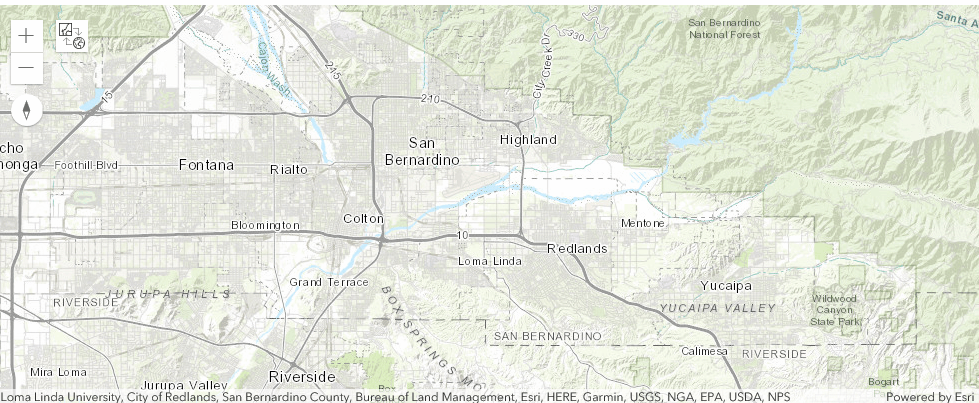

In [38]:
map3 = my_gis.map("Loma Linda, CA")
map3

In [42]:
colors1 = {0: [255, 255, 128, 90], 
          1: [128, 0, 128, 90],
          2: [0, 128, 0, 90], 
          3: [255, 255, 0, 90], 
          4: [255, 0, 0, 90]}

In [43]:
times = ['6 am', '10 am', '2 pm', '6 pm', '10 pm']
j=0
time.sleep(2)

for fset in loma_linda_fset_list:
    print(times[j])
    
    color1 = colors1[j]

    fill_symbol1 = SimpleFillSymbolEsriSFS(**{"type": "esriSFS","style": "esriSFSSolid",
               "color": color1,
               "outline":outline})
    
    map3.content.draw(fset, symbol=fill_symbol1)
    j+=1
    time.sleep(1)

6 am
10 am
2 pm
6 pm
10 pm


We have been using the `generate_service_areas` tool in the `network.analysis` module up to this point. From now on, let's use a different method - `create_service_areas` - defined in the `features.use_proximity` module, to achieve a workflow driven, Feature Service to Feature Service user experience.

### Method 2 - using arcgis.features.use_proximity.create_drive_time_areas

The create_drive_time_areas method creates areas that can be reached within a given drive time or drive distance. It can help you answer questions such as:

 - How far can I drive from here in five minutes?
 - What areas are covered within a three-mile drive distance of my stores?
 - What areas are within four minutes of our fire stations?

Parameters to be used in the following examples include:

 - `input_layer`: Required point feature layer. The points around which travel areas based on a mode of transportation will be drawn
 - `break_values`: Optional list of floats. The size of the polygons to create. The units for break_values is specified with the break_units parameter.
 - `time_of_day`: Optional datetime.datetime. Specify whether travel times should consider traffic conditions.
 - `context`: Optional dict. Context contains additional settings that affect task execution. For create_drive_time_areas, there are two settings - extent and outSR.
 - `output_name`: Optional string. Output feature service name. If not provided, a feature collection is returned.
 
In the following, we will explore the two approaches - with output_name specified, and without.

#### With output_name specified

When you have specified the `output_name` in the input parameters, the returned value from `create_drive_time_areas` is a feature layer collection.

In [46]:
"""If you are referencing the feature layer collection published from downloaded CSV
"""
hospital_layer = {'url': hospital_fl.url, 
                  'filter': "DBA_CITY='Redlands' or DBA_CITY='Loma Linda'"}

result2 = use_proximity.create_drive_time_areas(input_layer=hospital_layer, travel_mode='Driving Time',
                                                break_values=list_of_breaks, 
                                                time_of_day = current_time,
                                                context={'outSR': {"wkid": 4326}},
                                                output_name="Create Service Areas from Hospitals in SB County")

result2

{"cost": 54.0}


<Item title:"Create_Service_Areas_from_Hospitals_in_SB_County" type:Feature Layer Collection owner:arcgis_python>

A `FeatureLayer` object can be created from the item listed above, and hence we can make queries to it and get back a DataFrame object if `as_df` set to True.

In [47]:
service_area_sublayer = FeatureLayer.fromitem(result2, layer_id=0)
service_area_sublayer.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Create_Service_Areas_from_Hospitals_in_SB_County/FeatureServer/0'

In [48]:
sa_df = service_area_sublayer.query(where='1=1', as_df=True)[cols]
sa_df.sort_values('FromBreak', inplace=True, ascending=True)
sa_df.head()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME         DBA_ADDRESS1  \
2         0.0      5.0           36  San Bernardino    11234 Anderson St   
5         0.0      5.0           36  San Bernardino      25271 BARTON RD   
11        0.0      5.0           36  San Bernardino    11234 ANDERSON ST   
8         0.0      5.0           36  San Bernardino    11375 ANDERSON ST   
14        0.0      5.0           36  San Bernardino  24674 Redlands Blvd   

      DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
2   Loma Linda         92354     Parent Facility   
5   LOMA LINDA         92354     Parent Facility   
11  LOMA LINDA         92354     Parent Facility   
8   LOMA LINDA         92354     Parent Facility   
14  Loma Linda         92354     Parent Facility   

                                FACILITY_NAME FACILITY_STATUS_DATE  \
2   LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL           2014-11-16   
5         HERITAGE GARDENS HEALTH CARE CENTER           1966-01-11   
11       LOMA LINDA UNIVERSITY MEDICAL CENTER           1946-01-01   
8         LOMA LINDA UNIVERSITY KIDNEY CENTER           1977-12-19   
14                     CARELIFE HOSPICE, INC.           2020-07-14   

   FACILITY_STATUS_DESC        LICENSE_CATEGORY_DESC  LICENSE_NUM  \
2                  Open  General Acute Care Hospital    550002873   
5                  Open     Skilled Nursing Facility    240000146   
11                 Open  General Acute Care Hospital    240000169   
8                  Open      Chronic Dialysis Clinic    240000011   
14                 Open                      Hospice    550005664   

             LICENSE_TYPE_DESC                 Name   OSHPD_ID  \
2                     Hospital  Location 13 : 0 - 5  106364502   
5      Long Term Care Facility  Location 18 : 0 - 5  206361195   
11                    Hospital   Location 8 : 0 - 5  106361246   
8                       Clinic  Location 25 : 0 - 5  306360016   
14  Home Health Agency/Hospice  Location 34 : 0 - 5  406362791   

    TOTAL_NUMBER_BEDS  
2                 343  
5                 110  
11                371  
8                <NA>  
14               <NA>

In [49]:
sa_df.tail()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME        DBA_ADDRESS1  \
78        10.0     15.0           36  San Bernardino  700 E HIGHLAND AVE   
102       10.0     15.0           36  San Bernardino     42 W Hilton Ave   
99        10.0     15.0           36  San Bernardino      35 Blue Jay Ln   
96        10.0     15.0           36  San Bernardino          301 9th St   
105       10.0     15.0           36  San Bernardino      812 Concord Ln   

     DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
78   REDLANDS         92374     Parent Facility   
102  Redlands         92373     Parent Facility   
99   Redlands         92374     Parent Facility   
96   Redlands         92374     Parent Facility   
105  Redlands         92374     Parent Facility   

                        FACILITY_NAME FACILITY_STATUS_DATE  \
78   HIGHLAND CARE CENTER OF REDLANDS           1960-01-18   
102                 HILTON MANOR, LLC           2016-11-10   
99                BLUE JAY MANOR, LLC           2017-10-03   
96         WINGS OF HOPE HOSPICE, INC           2017-01-01   
105     SERENE CONGREGATE LIVING, LLC           2018-01-18   

    FACILITY_STATUS_DESC              LICENSE_CATEGORY_DESC  LICENSE_NUM  \
78                  Open           Skilled Nursing Facility    240000114   
102                 Open  Congregate Living Health Facility    550003708   
99                  Open  Congregate Living Health Facility    550003969   
96                  Open                            Hospice    550003546   
105                 Open  Congregate Living Health Facility    550004194   

              LICENSE_TYPE_DESC                   Name   OSHPD_ID  \
78      Long Term Care Facility  Location 16 : 10 - 15  206361114   
102     Long Term Care Facility  Location 24 : 10 - 15  206364580   
99      Long Term Care Facility  Location 15 : 10 - 15  206361004   
96   Home Health Agency/Hospice   Location 2 : 10 - 15  406361298   
105     Long Term Care Facility  Location 14 : 10 - 15  206360023   

     TOTAL_NUMBER_BEDS  
78                  80  
102                  6  
99                   6  
96                <NA>  
105                  6

Not only can we tabularize the result, but we can also render the output Feature Service on to the map widget (as below).


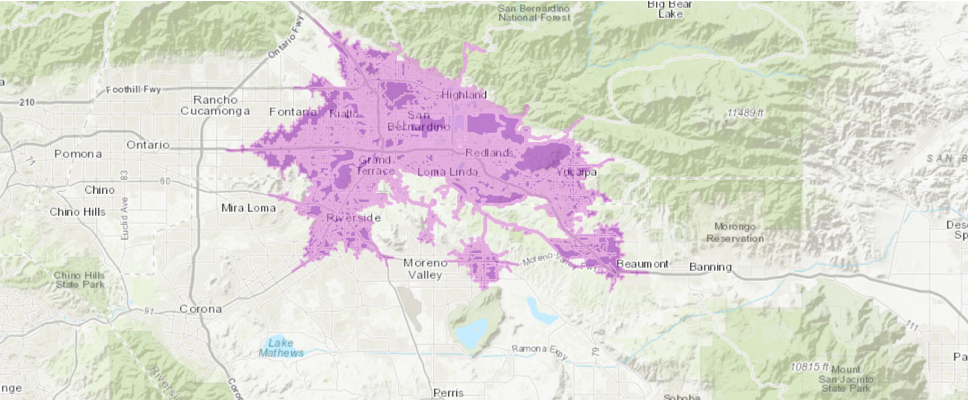

In [17]:
map4a = my_gis.map('SAN BERNARDINO, CA')
map4a

In [51]:
map4a.content.add(result2)

This concludes the workflow of Feature Service (as input) to Feature Service (as output) user experience. Next, let's use the same `use_proximity.create_drive_time_areas` but without the `output_name` specified, from which a `FeatureCollection` will be returned (instead of a Feature Service).

#### Without output_name specified

When you have not specified the `output_name` in the input parameters, the returned value from `create_drive_time_areas` is a FeatureCollection object, and detailed parsing needs to be done in order to get the information on demand.

In [52]:
%%time

result2b = use_proximity.create_drive_time_areas(input_layer=hospital_layer, travel_mode='Driving Time',
                                                break_values=list_of_breaks, 
                                                time_of_day = current_time,
                                                context={'outSR': {"wkid": 4326}})

{"cost": 54.0}


CPU times: total: 422 ms
Wall time: 34.7 s


In [53]:
result2b, result2b.query()

(<FeatureCollection>, <FeatureSet> 108 features)

##### Tabularizing the response from create_drive_time_areas

We can create a DataFrame out of the features contained in the returned FeatureCollection object.

In [54]:
df2 = result2b.query().sdf[cols]
df2.sort_values('FromBreak', inplace=True, ascending=True)
df2.head()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME         DBA_ADDRESS1  \
2         0.0      5.0           36  San Bernardino    11234 Anderson St   
5         0.0      5.0           36  San Bernardino      25271 BARTON RD   
11        0.0      5.0           36  San Bernardino    11234 ANDERSON ST   
8         0.0      5.0           36  San Bernardino    11375 ANDERSON ST   
14        0.0      5.0           36  San Bernardino  24674 Redlands Blvd   

      DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
2   Loma Linda         92354     Parent Facility   
5   LOMA LINDA         92354     Parent Facility   
11  LOMA LINDA         92354     Parent Facility   
8   LOMA LINDA         92354     Parent Facility   
14  Loma Linda         92354     Parent Facility   

                                FACILITY_NAME FACILITY_STATUS_DATE  \
2   LOMA LINDA UNIVERSITY CHILDREN'S HOSPITAL           2014-11-16   
5         HERITAGE GARDENS HEALTH CARE CENTER           1966-01-11   
11       LOMA LINDA UNIVERSITY MEDICAL CENTER           1946-01-01   
8         LOMA LINDA UNIVERSITY KIDNEY CENTER           1977-12-19   
14                     CARELIFE HOSPICE, INC.           2020-07-14   

   FACILITY_STATUS_DESC        LICENSE_CATEGORY_DESC  LICENSE_NUM  \
2                  Open  General Acute Care Hospital    550002873   
5                  Open     Skilled Nursing Facility    240000146   
11                 Open  General Acute Care Hospital    240000169   
8                  Open      Chronic Dialysis Clinic    240000011   
14                 Open                      Hospice    550005664   

             LICENSE_TYPE_DESC                 Name   OSHPD_ID  \
2                     Hospital  Location 13 : 0 - 5  106364502   
5      Long Term Care Facility  Location 18 : 0 - 5  206361195   
11                    Hospital   Location 8 : 0 - 5  106361246   
8                       Clinic  Location 25 : 0 - 5  306360016   
14  Home Health Agency/Hospice  Location 34 : 0 - 5  406362791   

    TOTAL_NUMBER_BEDS  
2                 343  
5                 110  
11                371  
8                <NA>  
14               <NA>

In [55]:
df2.tail()

FromBreak  ToBreak  COUNTY_CODE     COUNTY_NAME        DBA_ADDRESS1  \
78        10.0     15.0           36  San Bernardino  700 E HIGHLAND AVE   
102       10.0     15.0           36  San Bernardino     42 W Hilton Ave   
99        10.0     15.0           36  San Bernardino      35 Blue Jay Ln   
96        10.0     15.0           36  San Bernardino          301 9th St   
105       10.0     15.0           36  San Bernardino      812 Concord Ln   

     DBA_CITY  DBA_ZIP_CODE FACILITY_LEVEL_DESC  \
78   REDLANDS         92374     Parent Facility   
102  Redlands         92373     Parent Facility   
99   Redlands         92374     Parent Facility   
96   Redlands         92374     Parent Facility   
105  Redlands         92374     Parent Facility   

                        FACILITY_NAME FACILITY_STATUS_DATE  \
78   HIGHLAND CARE CENTER OF REDLANDS           1960-01-18   
102                 HILTON MANOR, LLC           2016-11-10   
99                BLUE JAY MANOR, LLC           2017-10-03   
96         WINGS OF HOPE HOSPICE, INC           2017-01-01   
105     SERENE CONGREGATE LIVING, LLC           2018-01-18   

    FACILITY_STATUS_DESC              LICENSE_CATEGORY_DESC  LICENSE_NUM  \
78                  Open           Skilled Nursing Facility    240000114   
102                 Open  Congregate Living Health Facility    550003708   
99                  Open  Congregate Living Health Facility    550003969   
96                  Open                            Hospice    550003546   
105                 Open  Congregate Living Health Facility    550004194   

              LICENSE_TYPE_DESC                   Name   OSHPD_ID  \
78      Long Term Care Facility  Location 16 : 10 - 15  206361114   
102     Long Term Care Facility  Location 24 : 10 - 15  206364580   
99      Long Term Care Facility  Location 15 : 10 - 15  206361004   
96   Home Health Agency/Hospice   Location 2 : 10 - 15  406361298   
105     Long Term Care Facility  Location 14 : 10 - 15  206360023   

     TOTAL_NUMBER_BEDS  
78                  80  
102                  6  
99                   6  
96                <NA>  
105                  6

##### Visualizing the response from create_drive_time_areas

For service area features contained in `result2b`, we can assign different colors to each service area based on their `ToBreak` value, and render a map of service areas from closer proximity to farther coverage.


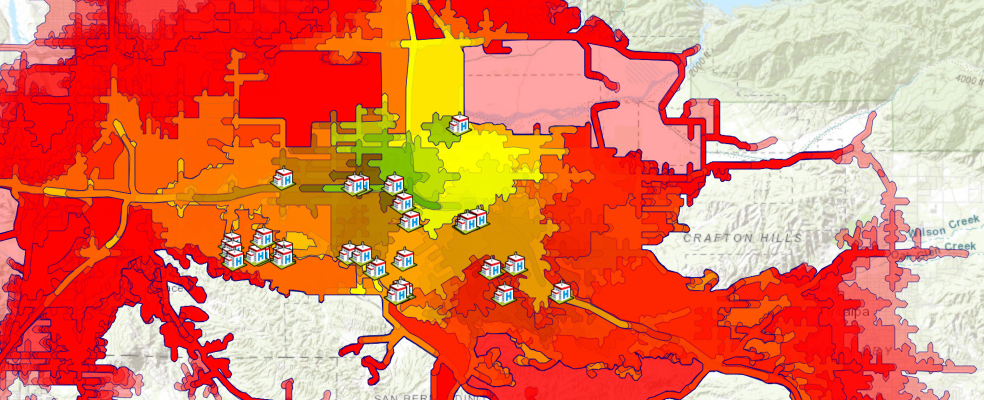

In [52]:
map4 = my_gis.map('SAN BERNARDINO, CA')
map4

Also customize the symbologies for the service areas and the facilities:

In [59]:
service_area_fset = result2b.query()
for f in service_area_fset.features:

    #set colors based on drive time
    color = colors[f.attributes['ToBreak']]

    fill_symbol = SimpleFillSymbolEsriSFS(**{"type": "esriSFS","style": "esriSFSSolid",
               "color": color,
               "outline":outline})
    
    #set popup
    popup=PopupInfo(**{"title": "Service area", 
           "content": "{} minutes".format(f.attributes['ToBreak'])})
    
    #draw service area
    map4.content.draw(f.geometry, symbol=fill_symbol, popup=popup, 
              attributes={"title": service_area.attributes['Name']})

# draw hospitals
map4.content.draw(facilities, symbol=hospital_symbol)

The service areas and the facilities shall be successfully rendered on `map4` now. Also, if you would like to save the map view as a web map, execute the following cell:

In [60]:
item_properties["title"] = "Hospital Service Areas of San Bernadino County (3)"
item = map4.save(item_properties)
item

<Item title:"Hospital Service Areas of San Bernadino County (3)" type:Web Map owner:arcgis_python>

In the last section of this guide, we have adopted a different method - `arcgis.features.use_proximity.create_drive_time_areas` - in generating service areas from facilities to areas accessible with a given time break. In doing so, we also explored the two scenarios with output_name specified (which forms a Feature Service to Feature Service user experience), and a more traditional compute/parse/draw approach when output_name is not present.

## What's next?

Part 3 has introduced `arcgis.network.analysis.generate_service_areas` and `arcgis.features.use_proximity.create_drive_time_areas` as solvers to the service area creating problem, how to prepare for data required as input arguments by these solvers, and ways to tabularize, map, and the save the output from solvers.

Now that we have mastered techniques in generating service areas, let's proceed to the next topic - finding closest facilities with `network.analysis` and `features.use_proximity` modules in [Part 4](../part4-find-closest-facilities)

## References

[1] Andy Mitchell, "The ESRI Guide to GIS Analysis, Volume 1: Geographic patterns & relationships", Esri Press, August 1999

[2] "Generate Service Areas", https://pro.arcgis.com/en/pro-app/latest/tool-reference/ready-to-use/itemdesc-generate-service-areas.htm, accessed on 09/24/2025

[3] "Make Service Area Layer", https://pro.arcgis.com/en/pro-app/latest/tool-reference/network-analyst/make-service-area-analysis-layer.htm, accessed on 09/24/2025